# HW 3 Problem 2: Heavy vs. Light Tails

In [1]:
import numpy as np
from scipy import stats
from scipy.special import gamma
from sklearn import linear_model
import matplotlib.pyplot as plt
import heapq

n = 10000 # Arbitrary plotting value for large n

## Part a: Law of Large Numbers

The law of large numbers states that as the sample size increases, the sample mean approaches the population mean. This aligns with what we see in the first two, as we expect the cumulative sum to grow linearly (with some errors) with n to maintain the value of slope close to the population mean. The Pareto distribution doesn't look linear due to the "some errors" being extremely large because of infinite variance. 

In [2]:
def make_graph_a(
    # Function to make our plots look nice
    xs,
    ys,
    distribution="Standard Normal",
    xlabel="Number of Variable Draws (n)",
    ylabel="Cumulative Sum"):
    """
    xs: List of x values to plot
    ys: List of y values to plot
    distribution: The name of the distribution that you are plotting
    """
    title = "{0} of {1} Distribution".format(ylabel, distribution)
    
    plt.subplots(1, 2, figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(xs[:20], ys[:20])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title + " (First 20 values)")

    plt.subplot(1, 2, 2)
    plt.plot(xs, ys)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    
    plt.show()
    

In [74]:
normal_draws = np.random.normal(loc=1, scale=1, size=n)
weibull_draws = np.random.weibull(a=0.3, size=n)
pareto_draws = np.random.pareto(a=0.5, size=n) * (1 / 3)

# Draw plots
# Instead of simulating for i=1...10^5 trials, take a partial sum
x_range = np.linspace(1, n, num=n)
normal_cumsum = np.cumsum(normal_draws)
weibull_cumsum  = np.cumsum(weibull_draws)
pareto_cumsum = np.cumsum(pareto_draws)

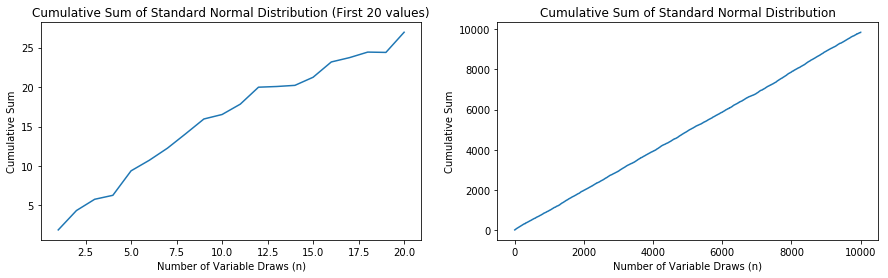

In [75]:
make_graph_a(
    x_range,
    normal_cumsum,
    distribution="Standard Normal")

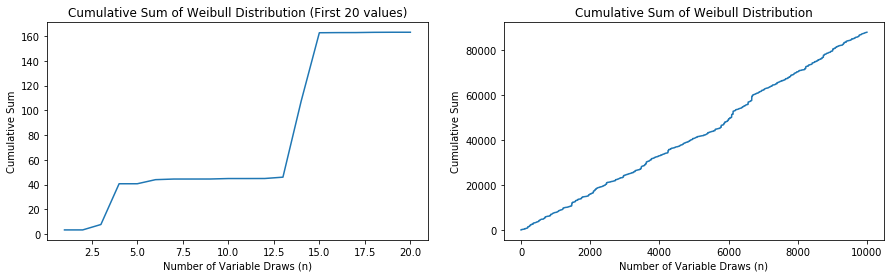

In [76]:
make_graph_a(
    x_range,
    weibull_cumsum,
    distribution="Weibull")

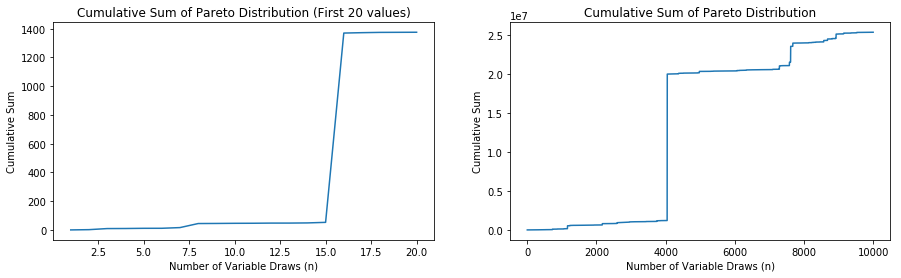

In [77]:
make_graph_a(
    x_range,
    pareto_cumsum,
    distribution="Pareto")

## Part b: Central Limit Theorem

The Central Limit Theorem tells us that deviations of $S_n$ from its mean are of size $\sqrt{n}$. That is, $S_n ≈ nE[X] + O(\sqrt{n})$. Plot $\frac{S_n − nE[X]}{\sqrt{n}}$ vs. $n$ for each of the distributions. **Interpret your plots, in light of the central limit theorem, and write your analysis here. Why aren't we also testing the Pareto distribution here?**

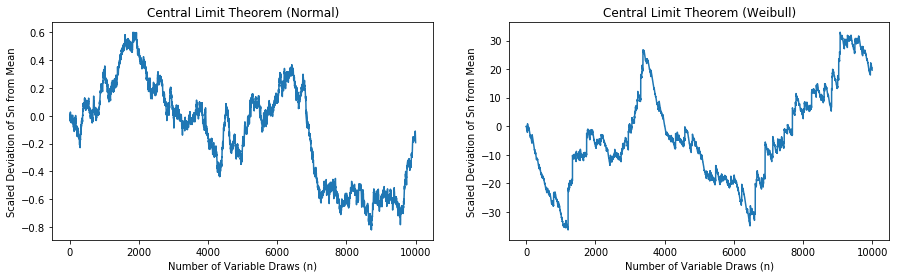

In [11]:
# TODO: Test the CLT by plotting the scaled deviation of Sn from its mean
# TODO: Why aren't we also testing the Pareto distribution here? 
# Use the cumulative sums and x_range from before
normal_mean = 1
weibull_mean = gamma(1 + 1 / 0.3)
normal_clt = (normal_cumsum - np.linspace(1, n, num=n) * normal_mean) / (n ** (1 / 2))
weibull_clt = (weibull_cumsum - np.linspace(1, n, num=n) * weibull_mean) / (n ** (1 / 2))

# Once the above variables are defined, we can make our plots
plt.subplots(1, 2, figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_range, normal_clt)
plt.xlabel("Number of Variable Draws (n)")
plt.ylabel("Scaled Deviation of Sn from Mean")
plt.title("Central Limit Theorem (Normal)")

plt.subplot(1, 2, 2)
plt.plot(x_range, weibull_clt)
plt.xlabel("Number of Variable Draws (n)")
plt.ylabel("Scaled Deviation of Sn from Mean")
plt.title("Central Limit Theorem (Weibull)")
plt.show()

## Part c: The 80-20 rule

Vilfredo Pareto was motivated to define the Pareto distribution by this observation: 80% of the wealth in society is held by 20% of the population. This is an important distinguishing feature between heavy-tailed and light-tailed distributions. To observe this, suppose that your samples represent the incomes of 10000 individuals in a city. Since some of your samples for the Normal distribution might be negative, ignore the case of the Normal distribution for this part of the problem, since a negative income doesn’t make much sense. Compute the fraction $f(r)$ of the total income of the city held by the wealthiest $r$% of the population, for $r$ = 1,2,· · ·,20. For each of the distributions, plot $f(r)$ vs. $r$. (preferably both functions on a singleplot). **Interpret your plot(s) and write your analysis here**.

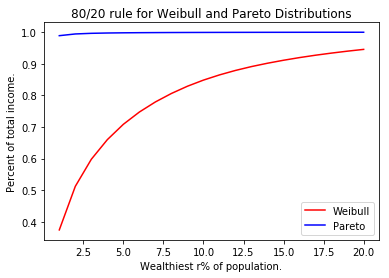

In [19]:
weibull_largest = [sum(heapq.nlargest(round(n * r / 100), weibull_draws)) for r in range(1, 21)] / sum(weibull_draws)
pareto_largest = [sum(heapq.nlargest(round(n * r / 100), pareto_draws)) for r in range(1, 21)] / sum(pareto_draws)

# Once the above lists are generated, we can make our plots
rRange = np.linspace(1, 20, num=20)

plt.plot(rRange, weibull_largest, 'r')
plt.plot(rRange, pareto_largest, 'b')
plt.xlabel("Wealthiest r% of population.")
plt.ylabel("Percent of total income.")
plt.title("80/20 rule for Weibull and Pareto Distributions")
plt.gca().legend(("Weibull", "Pareto"))
plt.show()

## Part d: Identifying Heavy Tails

For each of the distributions (i)–(iii), plot the frequencies and ranks of the 10000 samples on log-logscales, using separate plots for each distribution. Since we are using a log-log scale, filter out all negative and zero values before graphing. For the frequency plots, remember to experiment with various binsizes and to choose one such that the plots are useful. (Note that bins aren’t needed for the rank plot.) Then, use linear regression to fit a line through the points on each plot. Display the best-fit lines on theplots as well as the R-squared values. What do your plots tell you about identifying heavy tails basedon frequency and rank plots? **Interpret your plot(s) and write your analysis here**.

In [41]:
# Note: Feel free to modify this template as you wish or build your own from scratch.
# This is a tricky problem to implement so we hope we are helping by providing a template!

def pdf(data, dx=1):
    # Given a distribution's random samples, creates an approximate PDF of points
    # Use this when creating the frequency plot
    # Returns a tuple of two vectors x, y where 
    #   y_i = P(x_i - dx/2 <= data < x_i + dx/2)
    
    low, high = np.min(data), np.max(data)
    x, y = [], []
    
    for d in data:
        i = int((d + dx / 2 - low) / dx)
        xi = low + i * dx
        if xi in x:
            y[x.index(xi)] += 1
        else:
            x.append(xi)
            y.append(1)
    
    return np.array(x), np.array(y)
    
def ccdf(data):
    # Given a distribution's random samples, creates an approximate CCDF of points
    # Returns a tuple of two vectors x, y where 
    #   y_i = P(data > x_i)
    # Use this when creating the rank plot
    # TODO: Complete this function
    # HINT: To generate an approximate CDF (not CCDF), one would sort the random samples and 
    # return those as the x values, and then create a range from 1 to n
    # (scaled by 1/n) for the y values. How does this change when creating a CCDF?
    return np.sort(data), np.linspace(1, 0, n)

def keep_positive(data):
    # Filters out negative and zero entries (in both x and y) in data
    # TODO: Complete this function
    
    for i in range(3):
        # Indicates which entries to keep
        bool_array = np.logical_and(data[i][0] > 0, data[i][1] > 0)
        
        data[i] = (data[i][0][bool_array], data[i][1][bool_array])
    
    return data
 
def non_outliers(x, m):
    # Returns a list of boolean values determining whether or not
    # an entry is a non-outlier (centered entry is within m std devs) of the set x
    # TODO: Complete this function
    return abs(x - np.mean(x)) <= m * np.std(x)
    
def reject_outliers(data, m=3):
    # Removes all outliers from a generated distribution
    # Note that since we are plotting on log-log scale
    # Removing outliers should happen AFTER we move to log-log scale
    # TODO: Complete this function 
    # HINT: This function returns the (x, y) tuples in data that 
    # are not outliers (non_outliers() is helpful here)
    # HINT: You must set m to a default value that defines how many 
    # standard deviations away an outlier is. We are testing that 
    # these distributions are heavy-tailed, so too tight of a range 
    # won't be helpful.
    
    bool_arr = non_outliers(data[0], m)
    return data[0][bool_arr], data[1][bool_arr]
    
def linear_regression(X, Y):
    # Fits the linear model y = mx + b
    # Returns the best-fit values of m and b as well as r^2 on given data
    # TODO: Complete this function (return values should be m, b, r2)
    X = X.reshape(-1, 1)
    reg = linear_model.LinearRegression().fit(X, Y)
    return reg.coef_, reg.intercept_, reg.score(X, Y)

def make_graphs_d(data, title, labels, ylabel='', xlabel=''):
    """
    Build respective PDF/CCDF for all three distributions
    Attempts to create a best-fit line
    And plots this line alongside the points
    data: List of pdf() outputs from all 3 distributions
    title: Either 
        Frequency plot (PDF)
        Rank plot (CCDF)
    labels: List of distribution names
        i.e. ["Normal, Weibull, Pareto"]
    """
    # General plotting function for points, as well as best-fit line
    
    for (X, Y), label in zip(data, labels):
        m, b, r2 = linear_regression(X, Y)
        plt.scatter(X, Y, label=label, s=1)
        plt.plot(X, b + m * X, label='y = %.2f * x + %.2f, r2 = %.3f' % (m, b, r2))
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.show()

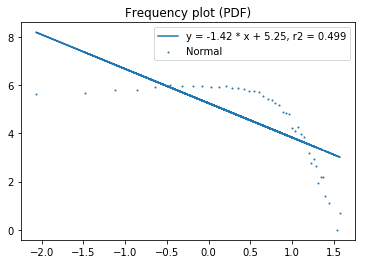

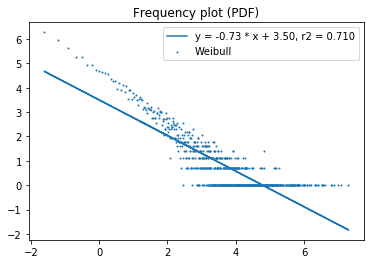

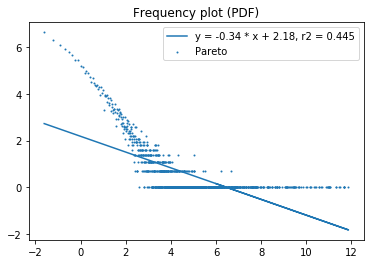

In [52]:
# Concatenate data into one list to reduce code repetition
Xi = [normal_draws, weibull_draws, pareto_draws]
names = ["Normal", "Weibull", "Pareto"]

# Build the PDF and turn it into a log-log scale,
# first removing all negative values and corresponding indices
# TODO: When (if at all) do we remove outliers here? 
# Before or after we convert to log-scale?
data = [pdf(Xi[i], dx=0.1) for i in range(3)]
data = keep_positive(data)
data = [(np.log(X), np.log(Y)) for (X, Y) in data]
data = [reject_outliers(data[i], 3) for i in range(3)]

# Plot the frequencies
make_graphs_d(data, 'Frequency plot (PDF)', names)

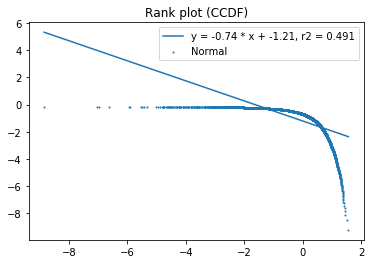

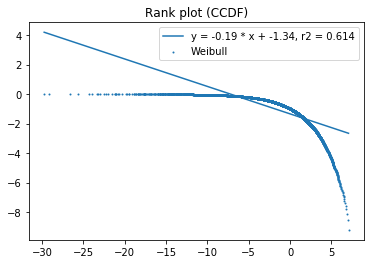

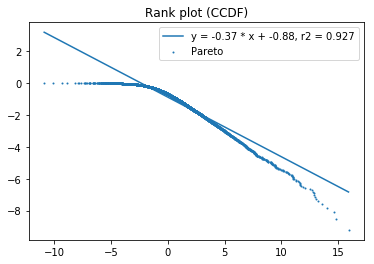

In [59]:
data = [ccdf(Xi[i]) for i in range(3)]

# Build the CCDF and turn it into a log-log scale,
# first removing all negative values and corresponding indices
# TODO: Do we remove outliers here?
data = keep_positive(data)
data = [(np.log(X), np.log(Y)) for (X, Y) in data]
# data = [reject_outliers(data[i], 3) for i in range(3)]

# Plot the ranks
make_graphs_d(data, 'Rank plot (CCDF)', names)